# Análise Exploratória de Dados Aprimorada: Clima vs. Testemunha (Para Apresentação)

Este notebook apresenta uma análise exploratória de dados comparando o tratamento de clima controlado com um grupo testemunha. O objetivo é extrair insights valiosos para uma apresentação, com foco em visualizações claras, comentários detalhados e explicações dos resultados.

## 1. Configuração e Carregamento de Dados
Nesta seção, importamos as bibliotecas necessárias e carregamos os dados de três fontes diferentes: `lote_performance_summary`, `daily_iot_summary` e `acompanhamento_lotes_data`. Esses dados são provenientes de um banco de dados SQLite.

In [2]:

import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Conexão com o banco de dados
engine = create_engine('sqlite:///../database/clima_prod.db')

# Carregamento dos DataFrames
df_performance = pd.read_sql('lote_performance_summary', engine)
df_iot = pd.read_sql('daily_iot_summary', engine)
df_acompanhamento = pd.read_sql('acompanhamento_lotes_data', engine)

print("DataFrames carregados com sucesso!")
print("Primeiras 5 linhas de df_performance:")
print(df_performance.head())
print("Primeiras 5 linhas de df_iot:")
print(df_iot.head())
print("Primeiras 5 linhas de df_acompanhamento:")
print(df_acompanhamento.head())
print("DataFrames carregados com sucesso!")

DataFrames carregados com sucesso!
Primeiras 5 linhas de df_performance:
  lote_composto data_alojamento   linhagem  aves_alojadas  aves_abatidas  \
0       1282-19      20/08/2025  COBB MALE          45992          41148   
1       1283-19      20/08/2025  COBB MALE          45992          41120   

   mortalidade_percent  idade_abate  conversao_ajustada  iep  peso_medio  \
0                10.53        41.48               1.731  390       3.105   
1                10.59        42.00               1.788  371       3.015   

   aero_parcial  condenacao_efetiva_kg  contaminacao_parcial  \
0        10.401               6898.756                 8.309   
1         7.067               4974.750                 3.397   

   remuneracao_sqr_meter_brl teste_realizado  
0                      23.61      TESTEMUNHA  
1                      22.67        CLIMA200  
Primeiras 5 linhas de df_iot:
  lote_composto Grandeza         Local        Data  average_valor max_valor  \
0       1282-19   AMÔNIA  

## 2. Limpeza e Preparação dos Dados

Esta seção é crucial para garantir a qualidade dos dados. Realizamos as seguintes etapas:

*   **Padronização de `lote_composto`**: Substituímos underscores por hífens para consistência.
*   **Renomear coluna**: A coluna `Idade` em `df_acompanhamento` é renomeada para `idade_lote`.
*   **Conversão de tipos de dados**: As colunas de data são convertidas para o formato datetime e valores numéricos são tratados para evitar erros.
*   **Fusão de DataFrames**: Os três DataFrames são unidos (`df_iot`, `df_acompanhamento`, `df_performance`) usando `lote_composto` e `idade_lote` como chaves, garantindo que todas as informações relevantes estejam em um único `df_final`.
*   **Filtragem de lotes**: Focamos apenas nos lotes de interesse (1282-19 e 1283-19) para esta análise.
*   **Padronização de `teste_realizado`**: O valor `CLIMA200` é substituído por `CLIMA` para uniformidade.

In [3]:

df_acompanhamento['lote_composto'] = df_acompanhamento['lote_composto'].str.replace('_', '-')
df_acompanhamento = df_acompanhamento.rename(columns={'Idade': 'idade_lote'})
df_performance['data_alojamento'] = pd.to_datetime(df_performance['data_alojamento'], format='%d/%m/%Y')
df_iot['Data'] = pd.to_datetime(df_iot['Data'], format='%d/%m/%Y', errors='coerce')
df_acompanhamento['Data'] = pd.to_datetime(df_acompanhamento['Data'], format='%d/%m/%Y', errors='coerce')
df_iot['max_valor'] = pd.to_numeric(df_iot['max_valor'], errors='coerce')
df_iot['min_valor'] = pd.to_numeric(df_iot['min_valor'], errors='coerce')

df_merged = pd.merge(df_iot, df_acompanhamento, on=['lote_composto', 'idade_lote'], how='outer', suffixes=('_iot', '_acomp'))
df_final = pd.merge(df_merged, df_performance, on='lote_composto', how='left', suffixes=('', '_perf'))

lotes_interesse = ['1282-19', '1283-19']
df_final = df_final[df_final['lote_composto'].isin(lotes_interesse)].copy()
df_final['teste_realizado'] = df_final['teste_realizado'].replace('CLIMA200', 'CLIMA')

print('Dados prontos para análise.')
print("Informações do DataFrame final após a limpeza e fusão:")
df_final.info()
print("Primeiras 5 linhas do DataFrame final:")
print(df_final.head())


Dados prontos para análise.
Informações do DataFrame final após a limpeza e fusão:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5300 entries, 0 to 5299
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   lote_composto              5300 non-null   object        
 1   Grandeza_iot               5300 non-null   object        
 2   Local                      5300 non-null   object        
 3   Data_iot                   5300 non-null   datetime64[ns]
 4   average_valor              5300 non-null   float64       
 5   max_valor                  4756 non-null   float64       
 6   min_valor                  4756 non-null   float64       
 7   std_valor                  5300 non-null   float64       
 8   amplitude_valor            5300 non-null   float64       
 9   idade_lote                 5300 non-null   int64         
 10  teste_realizado            5300 non-null   object

## 3. Análise Comparativa de Indicadores de Desempenho (KPIs)

Esta seção compara os principais Indicadores de Desempenho (KPIs) entre os tratamentos 'CLIMA' e 'TESTEMUNHA'. Os gráficos de barras permitem uma visualização rápida das diferenças médias em mortalidade, conversão alimentar, IEP (Índice de Eficiência Produtiva), peso médio e remuneração por metro quadrado.

**Insights para Apresentação:**
*   **Mortalidade:** Observe se há uma redução significativa na mortalidade no grupo CLIMA, indicando melhor bem-estar ou condições de criação.
*   **Conversão Alimentar:** Uma conversão alimentar menor no grupo CLIMA sugere maior eficiência na utilização da ração.
*   **IEP:** Um IEP mais alto é desejável, indicando melhor desempenho geral.
*   **Peso Médio:** Maior peso médio no grupo CLIMA pode significar um crescimento mais rápido e saudável.
*   **Remuneração:** A remuneração por m² é um KPI financeiro direto, mostrando o impacto econômico de cada tratamento.

Resumo dos KPIs por tratamento:
  teste_realizado  mortalidade_percent  conversao_ajustada    iep  peso_medio  \
0           CLIMA                10.59               1.788  371.0       3.015   
1      TESTEMUNHA                10.53               1.731  390.0       3.105   

   remuneracao_sqr_meter_brl  
0                      22.67  
1                      23.61  


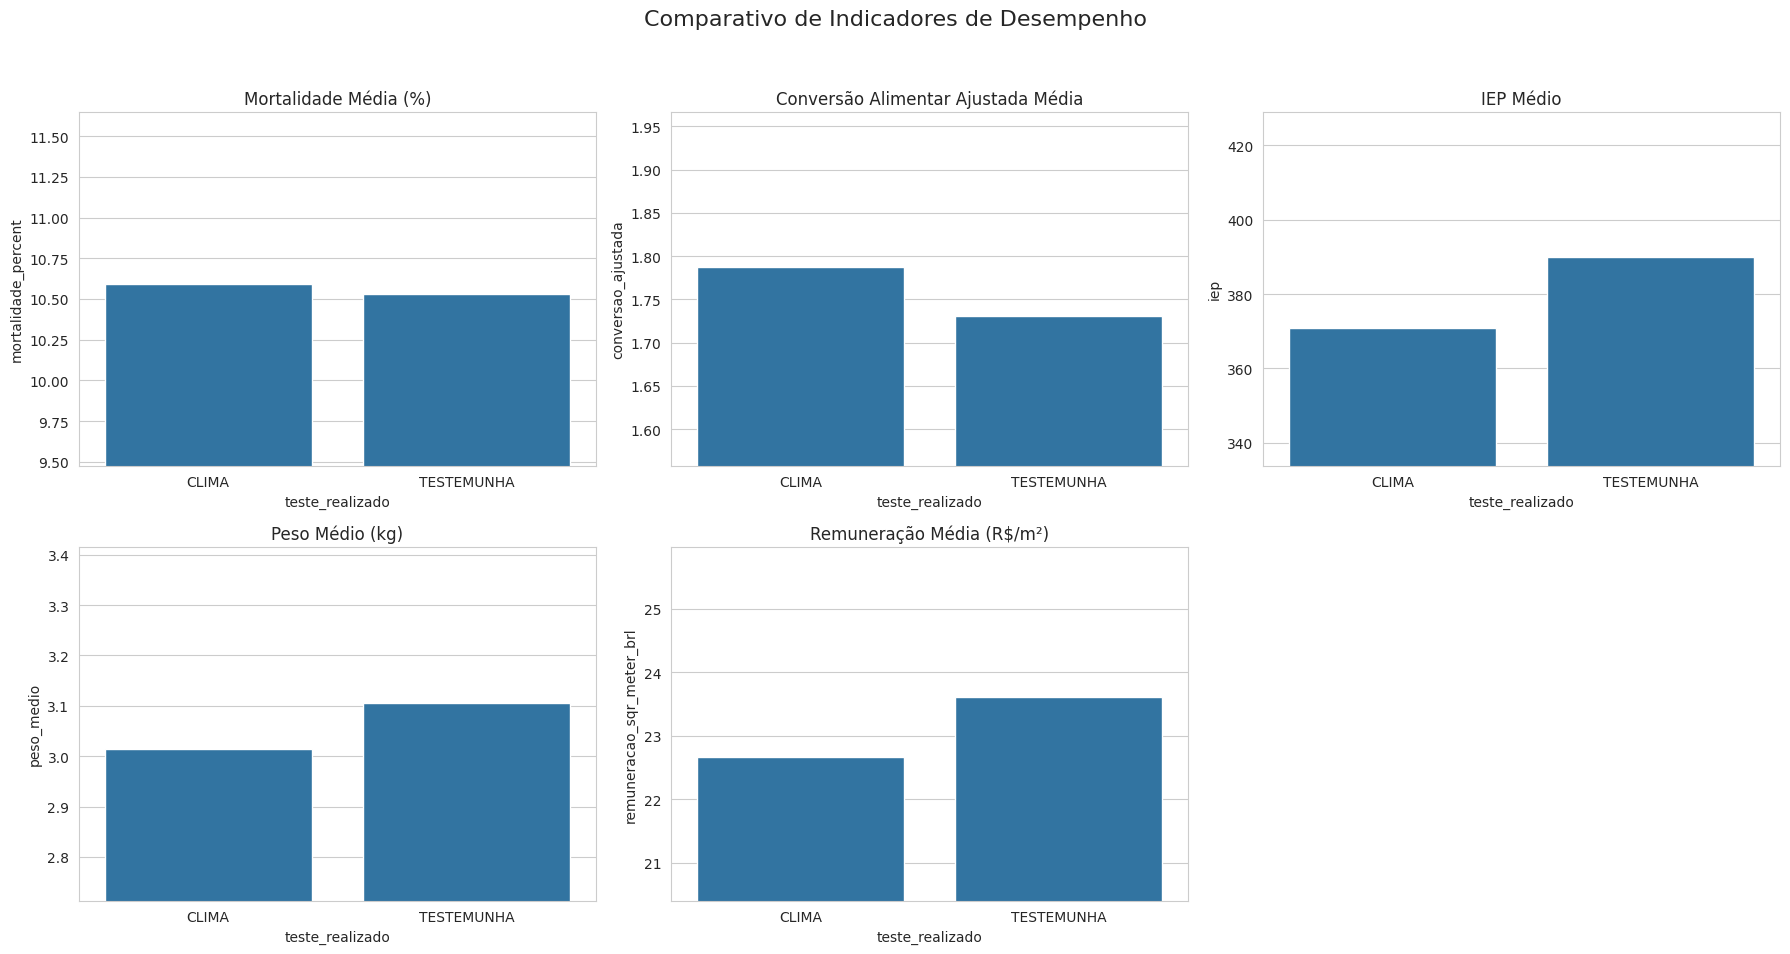

In [6]:

df_perf_summary = df_final.groupby('teste_realizado')[['mortalidade_percent', 'conversao_ajustada', 'iep', 'peso_medio', 'remuneracao_sqr_meter_brl']].mean().reset_index()

print("Resumo dos KPIs por tratamento:")
print(df_perf_summary)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparativo de Indicadores de Desempenho', fontsize=16)

# Mortalidade Média
sns.barplot(data=df_perf_summary, x='teste_realizado', y='mortalidade_percent', ax=axes[0, 0])
axes[0, 0].set_title('Mortalidade Média (%)')
axes[0, 0].set_ylim(df_perf_summary['mortalidade_percent'].min() * 0.9, df_perf_summary['mortalidade_percent'].max() * 1.1) # Ajuste dinâmico do y-lim

# Conversão Alimentar Ajustada Média
sns.barplot(data=df_perf_summary, x='teste_realizado', y='conversao_ajustada', ax=axes[0, 1])
axes[0, 1].set_title('Conversão Alimentar Ajustada Média')
axes[0, 1].set_ylim(df_perf_summary['conversao_ajustada'].min() * 0.9, df_perf_summary['conversao_ajustada'].max() * 1.1) # Ajuste dinâmico do y-lim

# IEP Médio
sns.barplot(data=df_perf_summary, x='teste_realizado', y='iep', ax=axes[0, 2])
axes[0, 2].set_title('IEP Médio')
axes[0, 2].set_ylim(df_perf_summary['iep'].min() * 0.9, df_perf_summary['iep'].max() * 1.1) # Ajuste dinâmico do y-lim

# Peso Médio (kg)
sns.barplot(data=df_perf_summary, x='teste_realizado', y='peso_medio', ax=axes[1, 0])
axes[1, 0].set_title('Peso Médio (kg)')
axes[1, 0].set_ylim(df_perf_summary['peso_medio'].min() * 0.9, df_perf_summary['peso_medio'].max() * 1.1) # Ajuste dinâmico do y-lim

# Remuneração Média (R$/m²)
sns.barplot(data=df_perf_summary, x='teste_realizado', y='remuneracao_sqr_meter_brl', ax=axes[1, 1])
axes[1, 1].set_title('Remuneração Média (R$/m²)')
axes[1, 1].set_ylim(df_perf_summary['remuneracao_sqr_meter_brl'].min() * 0.9, df_perf_summary['remuneracao_sqr_meter_brl'].max() * 1.1) # Ajuste dinâmico do y-lim

fig.delaxes(axes[1,2]) # Remover o subplot vazio
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Análise da Ambiência

Esta seção explora a evolução das principais variáveis de ambiência (Temperatura, Umidade Relativa, Amônia, CO2, Diferencial de Pressão) ao longo da idade do lote. Gráficos de linha comparam o comportamento dessas variáveis entre os tratamentos 'CLIMA' e 'TESTEMUNHA'.

**Insights para Apresentação:**
*   **Controle Ambiental:** Avalie se o tratamento CLIMA demonstra um controle mais estável e dentro das faixas ideais para cada variável.
*   **Flutuações:** Identifique se há menos flutuações ou picos indesejados no grupo CLIMA, o que pode impactar o estresse e a saúde das aves.
*   **Impacto nos KPIs:** Conecte o controle ambiental com os KPIs de desempenho. Por exemplo, um melhor controle de temperatura pode levar a uma melhor conversão alimentar.

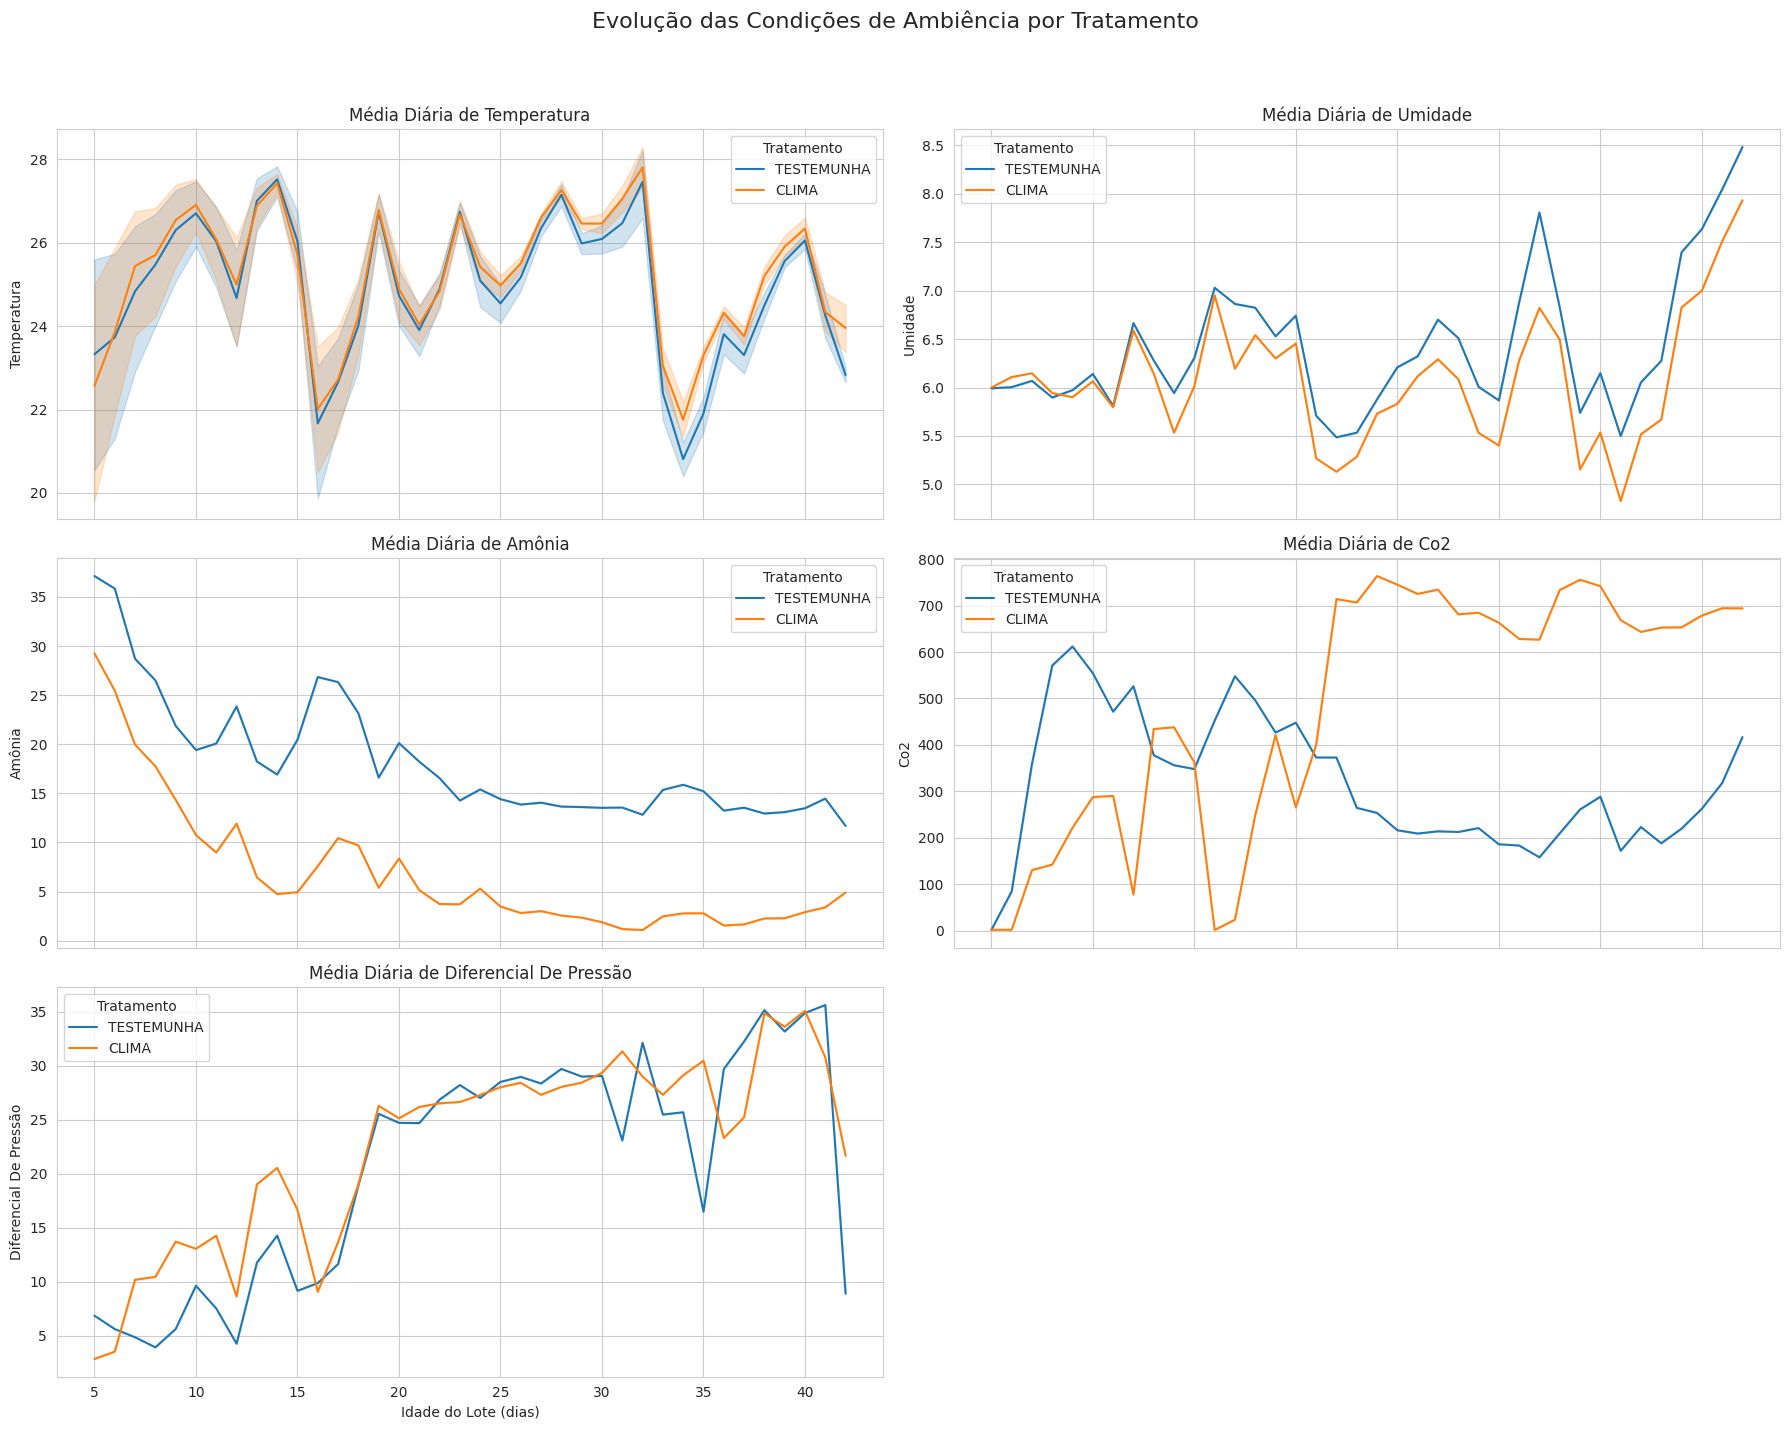

In [7]:

grandezas_amb_interesse = ['TEMPERATURA', 'UMIDADE', 'AMÔNIA', 'CO2', 'DIFERENCIAL DE PRESSÃO'] # Removendo 'PESO MÉDIO DA AVE', 'UNIFORMIDADE DO LOTE', 'PESOS QUALIFICADOS' que não são grandezas de ambiência diretas
df_amb = df_final[df_final['Grandeza_iot'].isin(grandezas_amb_interesse)]

fig, axes = plt.subplots(3, 2, figsize=(18, 15), sharex=True) # Ajustar grid para 3x2
fig.suptitle('Evolução das Condições de Ambiência por Tratamento', fontsize=16)

axes_flat = axes.flatten()

for i, grandeza in enumerate(grandezas_amb_interesse):
    sns.lineplot(data=df_amb[df_amb['Grandeza_iot'] == grandeza], x='idade_lote', y='average_valor', hue='teste_realizado', ax=axes_flat[i])
    axes_flat[i].set_title(f'Média Diária de {grandeza.title()}')
    axes_flat[i].set_ylabel(grandeza.title())
    axes_flat[i].set_xlabel('Idade do Lote (dias)')
    axes_flat[i].legend(title='Tratamento')

# Remover subplots vazios, se houver
for j in range(len(grandezas_amb_interesse), len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 5. Análise do Acompanhamento Diário

Esta seção apresenta a evolução diária de métricas importantes como mortalidade, consumo de energia, consumo de ração e Ganho Médio Diário (GMD). A comparação entre os tratamentos 'CLIMA' e 'TESTEMUNHA' pode revelar insights sobre o bem-estar, o desenvolvimento e a eficiência dos lotes ao longo do ciclo de produção.

**Insights para Apresentação:**
*   **Mortalidade Diária:** Picos de mortalidade podem indicar problemas de saúde ou estresse ambiental. Compare se o grupo CLIMA mantém uma mortalidade mais baixa e estável.
*   **Consumo de Energia:** Avalie o consumo de energia em KWh. Um consumo mais eficiente no grupo CLIMA pode ser um benefício econômico.
*   **Consumo de Ração:** O consumo de ração é diretamente ligado à conversão alimentar. Analise se o consumo é otimizado no grupo CLIMA para o ganho de peso.
*   **GMD:** O GMD é um indicador chave de crescimento. Um GMD consistentemente maior no grupo CLIMA demonstra um desenvolvimento superior das aves.

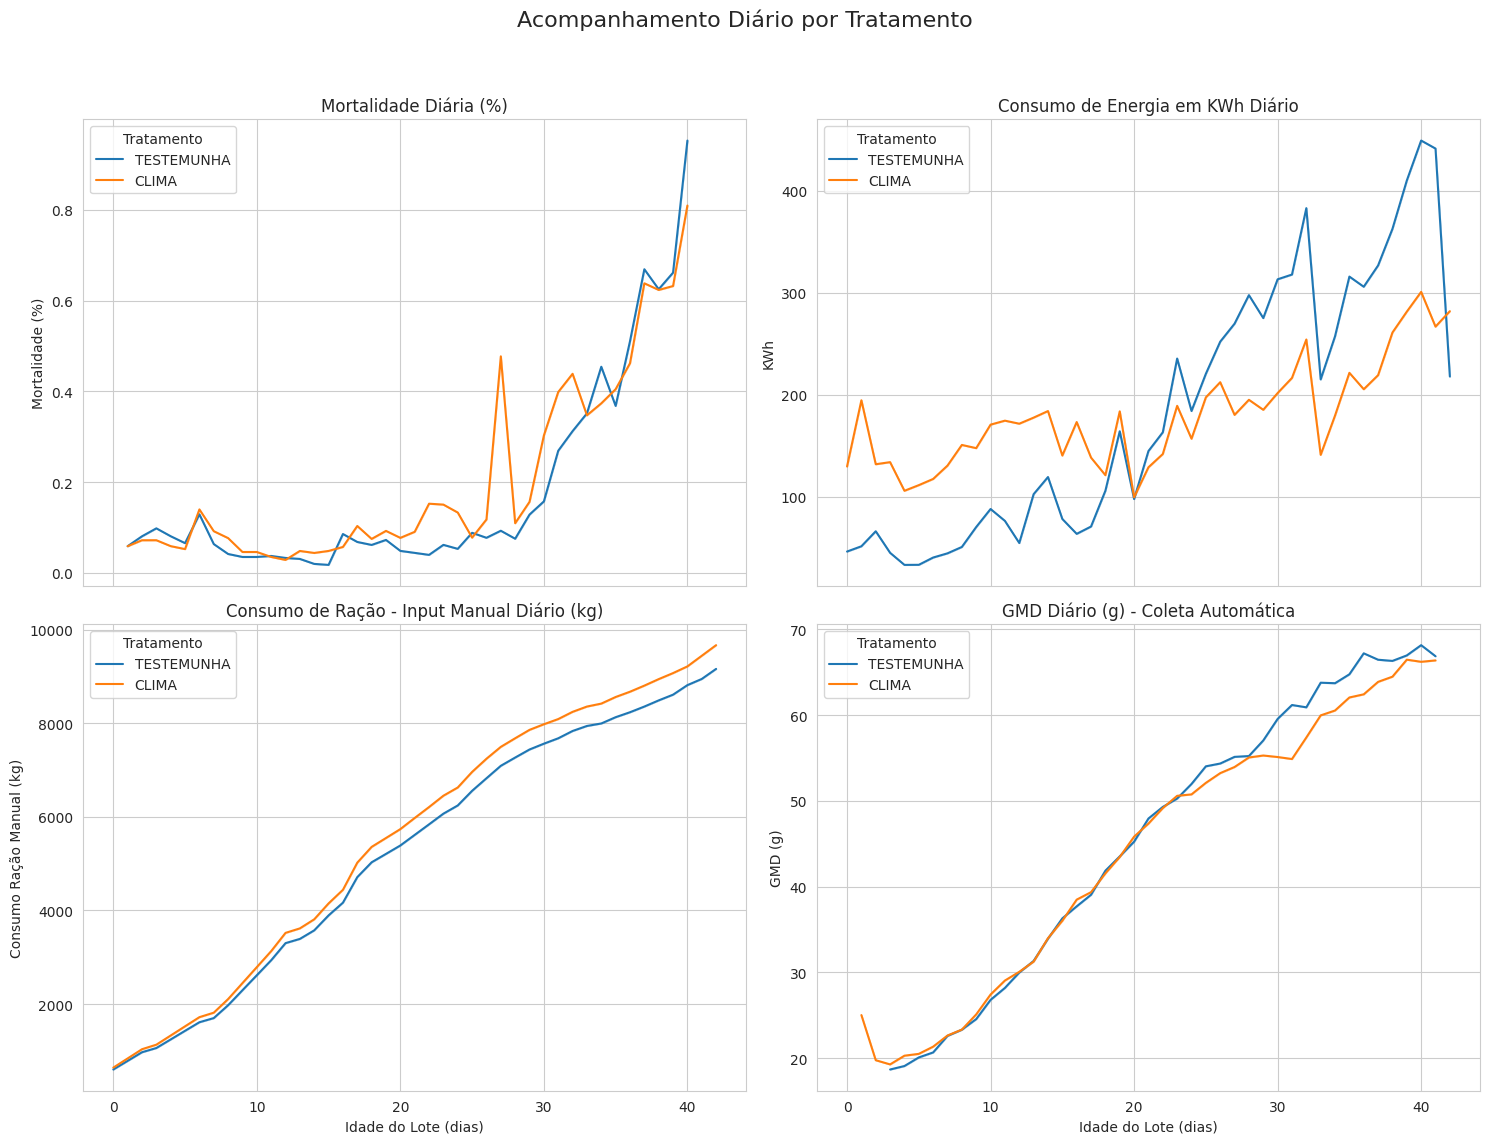

In [8]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
fig.suptitle('Acompanhamento Diário por Tratamento', fontsize=16)

# Mortalidade Diária (%)
sns.lineplot(data=df_final, x='idade_lote', y='Mortalidade_percent', hue='teste_realizado', ax=axes[0, 0])
axes[0, 0].set_title('Mortalidade Diária (%)')
axes[0, 0].set_ylabel('Mortalidade (%)')
axes[0, 0].set_xlabel('Idade do Lote (dias)')
axes[0, 0].legend(title='Tratamento')

# Consumo de Energia em KWh Diário
sns.lineplot(data=df_final, x='idade_lote', y='Consumo_automatico_kwh', hue='teste_realizado', ax=axes[0, 1])
axes[0, 1].set_title('Consumo de Energia em KWh Diário')
axes[0, 1].set_ylabel('KWh')
axes[0, 1].set_xlabel('Idade do Lote (dias)')
axes[0, 1].legend(title='Tratamento')

# Consumo de Ração - Input Manual Diário (kg)
sns.lineplot(data=df_final, x='idade_lote', y='Consumo_manual_kg', hue='teste_realizado', ax=axes[1, 0])
axes[1, 0].set_title('Consumo de Ração - Input Manual Diário (kg)')
axes[1, 0].set_ylabel('Consumo Ração Manual (kg)')
axes[1, 0].set_xlabel('Idade do Lote (dias)')
axes[1, 0].legend(title='Tratamento')

# GMD Diário (g) - Coleta Automática
sns.lineplot(data=df_final, x='idade_lote', y='GMD_automatico_g', hue='teste_realizado', ax=axes[1, 1])
axes[1, 1].set_title('GMD Diário (g) - Coleta Automática')
axes[1, 1].set_ylabel('GMD (g)')
axes[1, 1].set_xlabel('Idade do Lote (dias)')
axes[1, 1].legend(title='Tratamento')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
